In [38]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn import tree
from sklearn import svm

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/film-data/Cleaned_Data.csv
/kaggle/input/film-data/Common_Word.txt
/kaggle/input/film-data/Full_Raw_Data.csv


In [3]:
filename = '/kaggle/input/film-data/Cleaned_Data.csv'
data = pd.read_csv(filename)
data.head(1)

,Name,Certificate,Poster,Genre,Director,Writer,Stars,Storyline,Rating,Rating Count
0,The Dark Knight,PG-13,https://m.media-amazon.com/images/M/MV5BMTMxNT...,"Action, Crime, Drama",Christopher Nolan,"Jonathan Nolan, Christopher Nolan, David S. Goyer","Christian Bale, Heath Ledger, Aaron Eckhart, M...",When the menace known as the Joker wreaks havo...,9.0,2800000.0


In [4]:
def probability(y_test, y_hat, real=True, givenPredict=False):
    confusion_matrix = pd.crosstab(y_hat, y_test)
    if len(confusion_matrix.index) < 2:
        return float('inf')
    
    col1, col2 = confusion_matrix.columns
    row1, row2 = confusion_matrix.index
    
    real = col2 if real else col1
    givenPredict = row2 if givenPredict else row1
     
    p_real = confusion_matrix[real].sum() / confusion_matrix.sum().sum()
    p_notreal = confusion_matrix[real ^ col1 ^ col2].sum() / confusion_matrix.sum().sum()
    
    p_given_real = confusion_matrix[real][givenPredict] / confusion_matrix[real].sum()
    p_given_notreal = confusion_matrix[real ^ col1 ^ col2][givenPredict] / confusion_matrix[real ^ col1 ^ col2].sum()
    
    p_given = p_given_real * p_real + p_given_notreal * p_notreal
    
    p_real_given = p_given_real * p_real / p_given
    
    return p_real_given

In [5]:
data2['Country'].str.contains('India').sum()

NameError: name 'data2' is not defined

In [6]:
full_alphabet = 'qwertyuiopasdfghjklzxcvbnm'
count_char = {}
for char in full_alphabet:
    count_char[char] = data['Storyline'].str.lower().str.count(char)

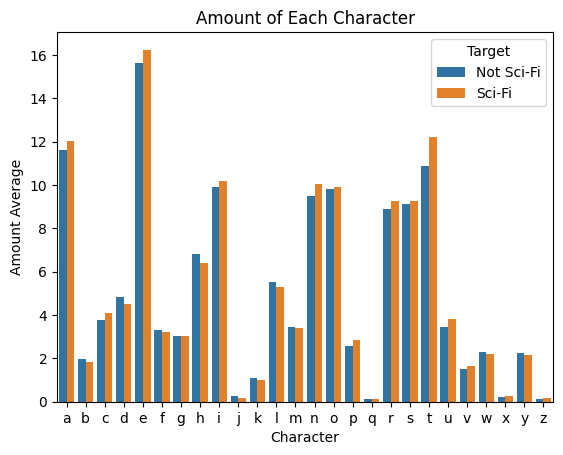

In [7]:
genre = 'Sci-Fi'
X = pd.DataFrame(data=count_char)
target = data['Genre'].str.contains(genre)
X['Target'] = target

X_melt = X.melt(id_vars=['Target'], 
                value_vars=[i for i in 'qwertyuiopasdfghjklzxcvbnm'], 
                var_name='Character', 
                value_name='Amount Average')

X_groupby = X_melt.groupby(['Target', 'Character']).mean().reset_index()
X_groupby.loc[X_groupby['Target'] == True, 'Target'] = 'Sci-Fi'
X_groupby.loc[X_groupby['Target'] == False, 'Target'] = 'Not Sci-Fi'

sns.barplot(X_groupby, x='Character', y='Amount Average', hue='Target')
plt.title('Amount of Each Character');

In [9]:
X_true = X[X['Target']].reset_index(drop=True)
X_false = X[~X['Target']].reset_index(drop=True)

In [35]:
np.random.seed(0)

n_true = int(X_true.shape[0] * 0.7)
choice_true = np.random.choice(X_true.shape[0], n_true, replace=False)
n_false = int(X_false.shape[0] * 0.7)
# n_false = X_false.shape[0] - (X_true.shape[0] - n_true)
choice_false = np.random.choice(X_false.shape[0], n_false, replace=False)

X_true_train = X_true[X_true.index.isin(choice_true)]
X_false_train = X_false[X_false.index.isin(choice_false)]
X_full_train = pd.concat([X_true_train, X_false_train]).sample(frac=1).reset_index(drop=True)

X_true_test = X_true[~X_true.index.isin(choice_true)]
X_false_test = X_false[~X_false.index.isin(choice_false)]
X_full_test = pd.concat([X_true_test, X_false_test]).sample(frac=1).reset_index(drop=True)

X_train = X_full_train[X_full_train.columns[~X_full_train.columns.isin(['Target'])]]
y_train = X_full_train['Target']

X_test = X_full_test[X_full_test.columns[~X_full_test.columns.isin(['Target'])]]
y_test = X_full_test['Target']

In [13]:
# Phân loại Sci-Fi bằng Decision Tree
DecisionTree = tree.DecisionTreeClassifier()
DecisionTree.fit(X_train, y_train)
y_pre = DecisionTree.predict(X_test)
print(skl.metrics.accuracy_score(y_test, y_pre))
confusion_matrix = pd.crosstab(pd.Series(y_pre, name='Predicted'), y_test)
print(confusion_matrix)
print(probability(y_test, y_pre, real=False, givenPredict=True))

0.9063638912251192
Target     False  True 
Predicted              
False       6444    303
True         365     22
0.9431524547803618


In [15]:
model = skl.linear_model.LogisticRegression()
model.fit(X_train, y_train)
y_hat = model.predict_proba(X_test)[:, 1] > 0.5
print(f'Accuracy: {skl.metrics.accuracy_score(y_test, y_hat)}')
print(f'Recall: {skl.metrics.recall_score(y_test, y_hat)}')
print(f'Precision: {skl.metrics.precision_score(y_test, y_hat)}')
print(f'F1: {skl.metrics.f1_score(y_test, y_hat)}')
confusion_matrix = pd.crosstab(pd.Series(y_hat, name='Predicted'), y_test)
confusion_matrix

Accuracy: 0.954443509952341
Recall: 0.0
Precision: 0.0
F1: 0.0


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Target,False,True
Predicted,,
False,6809,325


# Phân loại bằng SVC theo kiểu chia 20 phần

In [111]:
# Phân loại bằng SVC theo kiểu chia 20 phần
X_false_train = X_false_train.reset_index(drop=True)
X_true_train = X_true_train.reset_index(drop=True)

In [112]:
# Split X_false_train into 20 parts
choices = []
part_num = 20
list_choice = list(range(X_false_train.shape[0]))
n = X_false_train.shape[0] // part_num
for i in range(part_num-1):
    choice = np.random.choice(list_choice, n, replace=False)
    choices.append(choice)
    for j in choice:
        list_choice.remove(j)
choices.append(np.array(list_choice))

In [113]:
n = X_true_train.shape[0]
models = []
for choice in choices:
    choice_true = np.random.choice(n, 3*n//4, replace=False)
    X_true_train_choice = X_true_train[X_true_train.index.isin(choice_true)]
    X_false_train_choice = X_false_train[X_false_train.index.isin(choice)]
    
    X_full_train = pd.concat([X_true_train_choice, X_false_train_choice]).sample(frac=1).reset_index(drop=True)
    
    X_train = X_full_train[X_full_train.columns[~X_full_train.columns.isin(['Target'])]]
    y_train = 2 * X_full_train['Target'] - 1
    
    model = svm.SVC()
    model.fit(X_train, y_train)
    models.append(model)

In [114]:
y_hat = models[0].predict(X_test)
for i in range(1, part_num):
    y_pre = 2 * (models[i].predict(X_test)) - 1
    y_hat += y_pre
y_hat = (y_hat >= 0)

In [115]:
print(skl.metrics.accuracy_score(y_test, y_hat))
print(skl.metrics.recall_score(y_test, y_hat))
pd.crosstab(y_hat, y_test, rownames=['Predicted'])

0.8557611438183347
0.2676923076923077


Target,False,True
Predicted,,
False,6018,238
True,791,87


# Phân loại bằng SVC theo kiểu chia 20 phần

In [106]:
# Split X_false_train into 40 parts
choices = []
part_num = 20
list_choice = list(range(X_false_train.shape[0]))
n = X_false_train.shape[0] // part_num
for i in range(part_num-1):
    choice = np.random.choice(list_choice, n, replace=False)
    choices.append(choice)
    for j in choice:
        list_choice.remove(j)
choices.append(np.array(list_choice))

In [107]:
n = X_true_train.shape[0]
models = []
for choice in choices:
    choice_true = np.random.choice(n, int(20/part_num*3*n/4), replace=False)
    X_true_train_choice = X_true_train[X_true_train.index.isin(choice_true)]
    X_false_train_choice = X_false_train[X_false_train.index.isin(choice)]
    
    X_full_train = pd.concat([X_true_train_choice, X_false_train_choice]).sample(frac=1).reset_index(drop=True)
    
    X_train = X_full_train[X_full_train.columns[~X_full_train.columns.isin(['Target'])]]
    y_train = 2 * X_full_train['Target'] - 1
    
    model = tree.DecisionTreeClassifier()
    model.fit(X_train, y_train)
    models.append(model)

In [108]:
y_hat = models[0].predict(X_test)
for i in range(1, part_num):
    y_hat += models[i].predict(X_test)
y_hat = (y_hat >= 0)

In [109]:
print(skl.metrics.accuracy_score(y_test, y_hat))
pd.crosstab(y_hat, y_test, rownames=['Predicted'])

0.6770395290159799


Target,False,True
Predicted,,
False,4676,171
True,2133,154


In [33]:
skl.metrics.accuracy_score(y_test, y_hat)

0.38800112139052423

In [37]:
from sklearn import svm
clf = svm.LinearSVC()
clf.fit(X_train, y_train)
y_hat = clf.predict(X_test)
print(skl.metrics.accuracy_score(y_test, y_hat))
pd.crosstab(y_hat, y_test, rownames=['Predicted'])

0.954443509952341


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Target,False,True
Predicted,,
False,6809,325
